<h2><b>IMPORTANT</b></h2> 
There are parts in this jupyter notebook which depend on private API keys. If you do not have a .env file with the keys in this directory, they will not work. Sections which require API keys will be declared explicitly. Alterantives will be provided to those not wishing to create their own API keys. For example, connecting to the Sepolia testnet requires a gateway, which we will require an API to access, as well as an API key to get access to the network itself.

Disclosure - metrics provided in the report have been taken from running transactions on the <b>Sepolia testnet</b>, if you do not wish to supply API keys you will be using a local network. The metrics (gas cost) may not be the same however functionality is the exact same.


.env structure:

GATEWAY_URL=[your url here]<br>
GATEWAY_TOKEN=[your token here]<br>
PINATA_API_KEY=[your pinata api key here]<br>
INFURA_API_KEY=[your infura api key here]<br>
SEPOLIA_PRIVATE_KEY=[your sepolia api key here]

Imports any packages. 

You will need a valid node.js installation, see <a>https://nodejs.org/en/learn/getting-started/how-to-install-nodejs</a> for support with this.<br>

Note: 
- these commands will run in the shell, for full dependencies and package str(base64.b64encode please see package.json file.
- Most of the code for contract interaction have been done via JS scripts. This jupyter notebook will run the scripts rather than create python code for interaction on top of the already existant JS code. If you wish to read the JS code, see the scripts folder for the relevant file. This is done mainly to save my time so that I can actually meet the project deadline instead of spending time on migrating code between languages for demonstration purposes. While I could probably create the same functionality in Python, APIs are not as extensive and so I will likely have to encode data manually (or at least spend a lot of time creating a dynamic encoding approach, whereas the web3.js or ethers.js modules do a lot of the heavy lifting for us, even compared to web3.py which does not include many features). 


In [ ]:
! npm install
# You might get some errors with installing node packages from the jupyter notebook, 
# if so then just run the commands in the terminal
! pip install -r requirements.txt
import os
import json
import requests
from dotenv import load_dotenv
load_dotenv()
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from base64 import b64encode, b64decode
# Make the sample and metrics directories if they dont exist, this is where we will store temp files for the demo
path = os.path.join(os.getcwd(), 'sample') 
try:
    os.mkdir(path)
except:
    pass
try:
    os.mkdir(os.path.join(path, 'metrics') )
except:
    pass
try:
    os.mkdir(os.path.join(path, 'graphs') )
except:
    pass

First, the issuance and verification contracts are deployed by the issuer. Only the issuer (the owner) can call functions on the contract. We need to have a contract deployed before we can upload any credentials to IPFS because we will need the contract addresses for issuence and verification (so that the verifier can verify without needing to know any prior information, more on this later).

If you have set up your Infura (or Equivalent) and Sepolia API keys, run code block 1. Otherwise run code block 2.

If running code block 2, you will need to start a local node. The command is:<br>
- npx hardhat node

copy this into a seperate terminal and keep it open

In [ ]:
# Code block 1.
# run only if you have set up your API keys for sepolia network interaction
# don't worry if the code hangs for a while, it takes a bit of time

! npx hardhat compile
! npx hardhat run scripts/demo/deploy.ts --network sepolia 

In [2]:
# Code block 2.
# run network on localhost
# you will need to run the following command in a seperate terminal on your computer: npx hardhat node
# to create a local node
! npx hardhat compile
! npx hardhat run scripts/demo/deploy.ts --network localhost



Nothing to compile
No need to generate any newer typings.


Issue deployed to 0x5FbDB2315678afecb367f032d93F642f64180aa3, with owner at 0xf39Fd6e51aad88F6F4ce6aB8827279cffFb92266
Verify deployed to 0xa16E02E87b7454126E5E10d957A927A7F5B5d2be, with linked issue contract at 0x5FbDB2315678afecb367f032d93F642f64180aa3


Since address can change between contract deployments, we will save the addresses to a file called addresses.json in the sample/ folder.

In a real use case, the issuer would similarly save the addresses somewhere in their internal systems. Both the verifier and issuer contract addresses will never change (unless they deploy a new issuence contract) so they will only have to save it once.

In [3]:
with open('sample/addresses.json', 'r') as f:
    data=f.read()
f.close()

obj = json.loads(data)
issue_address = obj['issue_contract_address']
issuer_address = obj['issuer_address']
verify_address = obj['verify_contract_address']
holder_addresses = obj['holder_addresses']

The issuer can then create a credential expressed in JSON, following the W3C verifiable credential data model guidelines <a>https://www.w3.org/TR/vc-data-model/</a>. There is one attribute added from those in the W3C data model, which is "metadata". In this attribute we include the the issue and verify contract addresses so that the verifier, when sent the verifiable presentation, can directly verify the credential without having to require any pre-existing knowledge. Information of the expected attributes in the metadata object would be outlined from one of the URI in @context.

For this demonstration, parsing of credential fields will not be done after the credential is verified in this framework. Some URIs in the credential may not be resolvable but for real implementations should be. These can be resolvable via typical http(s) protocol or via interplantary file system (ipfs) (more on this later).

what is IPFS? <a>https://ipfs.tech/developers/</a><br>
in short, a distributed network which we can use to permentantly store files. Once a file is uploaded, IPFS generates a content identifier (CID) based on the content in the file. This CID only ever points to one resource. If the same resource is uploaded will slight modifications, the CID changes. This makes resources on IPFS immutable.

In [4]:
# create an example JSON credential and save it a file in sample folder
# need to conver byte arrays to strings to save to json file, can be converted back later
decrypt_info = []
ciphers = []
for i in range(12):
  key = get_random_bytes(16)
  cipher = AES.new(key, AES.MODE_EAX)
  decrypt_info.append({"key": b64encode(key).decode('utf-8'),
   "nonce": b64encode(cipher.nonce).decode('utf-8')})
  ciphers.append(cipher)

cred = {
    "@context":[
        "https://www.w3.org/2018/credentials/v1",
        "ipfs://12345"
    ],
    "metadata":{
      "issue_address": issue_address,
      "verify_address": verify_address,
      "network":"Ethereum-mainnet",
    },
    "first_name": b64encode(ciphers[0].encrypt(b'John')).decode('utf-8'),
    "last_name": b64encode(ciphers[1].encrypt(b'Doe')).decode('utf-8'),
    "date_birth": b64encode(ciphers[2].encrypt(b'1995-12-26T00:00:00.000Z')).decode('utf-8'),
    "place_birth": b64encode(ciphers[3].encrypt(b'Aberdeen')).decode('utf-8'),
    "issuence_date": b64encode(ciphers[4].encrypt(b'2020-11-20T00:00:00.000Z')).decode('utf-8'),
    "expiration": b64encode(ciphers[5].encrypt(b'2025-11-20T00:00:00.000Z')).decode('utf-8'),
    "issuing_authority": b64encode(ciphers[6].encrypt(b'DVLA')).decode('utf-8'),
    "driver_number": b64encode(ciphers[7].encrypt(b'12345')).decode('utf-8'),
    "photo": b64encode(ciphers[8].encrypt(b'https://a_link_to_somewhere/photo.jpg')).decode('utf-8'),
    "holder_address": b64encode(ciphers[9].encrypt(b'20 Bogus Street, Somewhere')).decode('utf-8'),
    "entitlements": [
      {
        "category": b64encode(ciphers[10].encrypt(b'B1')).decode('utf-8'),
        "valid_from": b64encode(ciphers[10].encrypt(b'2020-11-20T00:00:00.000Z')).decode('utf-8'),
        "valid_to": b64encode(ciphers[10].encrypt(b'2025-11-20T00:00:00.000Z')).decode('utf-8')
      },
      {
        "category": b64encode(ciphers[11].encrypt(b'A3')).decode('utf-8'),
        "valid_from": b64encode(ciphers[11].encrypt(b'2020-11-20T00:00:00.000Z')).decode('utf-8'),
        "valid_to": b64encode(ciphers[11].encrypt(b'2025-11-20T00:00:00.000Z')).decode('utf-8')
      }
    ],
    "proof": {
        "type": "Ed25519Signature2020",
        "created": "2021-11-13T18:19:39Z",
        "verificationMethod": "https://example.edu/issuers/14#key-1",
        "proofPurpose": "assertionMethod",
        "proofValue": "z58DAdFfa9SkqZMVPxAQpic7ndSayn1PzZs6ZjWp1CktyGesjuTSwRdoWhAfGFCF5bppETSTojQCrfFPP2oumHKtz"
    }
}
with open(path+"/credential.json", 'w') as f:
  json.dump(cred, f, ensure_ascii=False, indent=4)

print("You can view the encrypted credential in sample/credential.json")

You can view the encrypted credential in sample/credential.json


JSON files cannot hold bytes type directly so I convert to b64encode so that it can be converted back, I had problems with string encoding, I am sure there is a better way to do it but the implementation of the sepcific encryption algorithm is not of concern to this framework, as long as it meets the requirements:
- data can be encrypted and stored in a decentralised location
- key can be transfered securely
- if someone holds key(s) or other secret information, they can decrypt the data store in decentralised location
- the usual cryptographic security requirements (data not decryptable without key, cannot infer plaintext from ciphertext, etc.)

Notice in the @context attribute we have an ipfs protocol URI. This is a resource which is stored on the decentralised ipfs network and found in just the same way that this credential was found. This alleviates the potential issue of Issuers changing data which invalidates credential integrity, since resources stored via ipfs are immutable. 

Credential claims are encrypted. The Issuer then supplies the holder with all the keys for each claim. Each claim is encrypted using a seperate key. Later the holder will selectively send keys to the Verifier depending on the claims they wish to reveal (explained further later).

For now we will bundle the keys into a similar object as above. This is still digitally signed (requires a proof) and still needs the @context so it it can be machine readable.


In [5]:
cred_keys = {
    "@context":[
        "https://www.w3.org/2018/credentials/v1",
        "https://example.edu/credential_keys_layout#drivers_licences"
    ],
    "metadata":{
      "issue_address": issue_address,
      "verify_address": verify_address,
      "network":"Ethereum-mainnet",
    },
    "first_name": decrypt_info[0],
    "last_name": decrypt_info[1],
    "date_birth": decrypt_info[2],
    "place_birth": decrypt_info[3],
    "issuence_date": decrypt_info[4],
    "expiration": decrypt_info[5],
    "issuing_authority": decrypt_info[6],
    "driver_number": decrypt_info[7],
    "photo": decrypt_info[8],
    "holder_address": decrypt_info[9],
    "entitlements": [
      {
        "category": decrypt_info[10],
        "valid_from": decrypt_info[10],
        "valid_to": decrypt_info[10]
      },
      {
        "category": decrypt_info[11],
        "valid_from": decrypt_info[11],
        "valid_to": decrypt_info[11]
      }
    ],
    "proof": {
        "type": "Ed25519Signature2020",
        "created": "2021-11-13T18:19:39Z",
        "verificationMethod": "https://example.edu/issuers/14#key-1",
        "proofPurpose": "assertionMethod",
        "proofValue": "z58DAdFfa9SkqZMVPxAQpic7ndSayn1PzZs6ZjWp1CktyGesjuTSwRdoWhAfGFCF5bppETSTojQCrfFPP2oumHKtz"
    }
}
with open(path+"/credential_keys.json", 'w') as f:
  json.dump(cred_keys, f, ensure_ascii=False, indent=4)

print("You can view the generate keys in sample/credential_keys.json")


You can view the generate keys in sample/credential_keys.json


There is possibility to extend the implementation to allow access privilege to others, however this was not done for this implementation for simplicity. For potential implementations to grant/revoke roles see <a>https://docs.openzeppelin.com/contracts/3.x/access-control</a>

A potential use case for this might be:
- A verified licening authority (lets say DVLA for drivers licences) creates an issuence and verification smart contract. The owner virtual address is the only one who can access any methods in the smart contract at first. The owner can then selectively authorise other address to call methods on the smart contract (create licences). The DVLA would likely authorise virtual addresses of multiple machines which they use to issue licence, over multiple locations, instead of just the one.

Now that the issuer has the credential, they will upload it to the IPFS. This can be done through any IPFS gateway.

There are two options:
- Upload via pinata API using python in Block 1.
- Block 2 is done via JS script. Uses the pinata API to add files to IPFS. You will need to configure pinata keys.
- Block 3 if you haven't configured your API keys.


Block 1 and 2 are equivalent.

Optionally, you can set up a local ipfs daemon and upload/fetch through there.

In [6]:
# Block 1

url = "https://api.pinata.cloud/pinning/pinJSONToIPFS"
id = "sample_credential"
payload = {
    "pinataContent": cred,
    "pinataMetadata": {"name": id},
    "pinataOptions": {"cidVersion": 1}
}
headers = {
    "Authorization": "Bearer {}".format(os.getenv('PINATA_API_KEY')),
    "Content-Type": "application/json"
}

response = requests.request("POST", url, json=payload, headers=headers)
CID = json.loads(response.text)['IpfsHash']
print("uploaded with CID:", CID)

with open(path+"/CIDs.json", 'w') as f:
  json.dump({"CID":CID, "id":id}, f, ensure_ascii=False, indent=4)

uploaded with CID: bafkreia6jemlfe2yl535mnewwsnil5so6pbf6hubbp5richzieftbb5ij4


In [ ]:
# Block 2
# via JS script
!npx hardhat run scripts/demo/upload_credentials.ts

In [ ]:
# Block 3
# skip IPFS upload
with open(path+"/CIDs.json", 'w') as f:
  json.dump({"CID":"bafkreia6jemlfe2yl535mnewwsnil5so6pbf6hubbp5richzieftbb5ij4", "id":"sample_credential"}, f, ensure_ascii=False, indent=4)

Issue and Verify contracts are now deployed. Now the Issuer will send a transaction to the issuance contract to create a credential NFT and bind it to a holder's virtual address (make them the owner). The Issuer will supply the CID of the credential.json folder uploaded via IPFS earlier. This will serves as the NFT's URI.


- Block 1 runs a JS script to create a licence NFT on the sepolia public testnet (you need to configure your keys).<br>
- Block 2 runs a JS script to create a licence NFT on a local network (remember you need to start a local node first for this to work with command: npx hardhat node)

scripts will generate a NFTs.json file in the sample folder which will contain the NFT id and the address of the holder.

In [ ]:
# Block 1
# Needs infura and sepolia keys configured
!npx hardhat run scripts/demo/issue.ts --network sepolia

In [7]:
# Block 2
# Needs local node running
# do following command in seperate terminal: npx hardhat node
!npx hardhat run scripts/demo/issue.ts --network localhost



NFT create with id: 0, to holder with address: 0x70997970C51812dc3A010C7d01b50e0d17dc79C8


Now we will assume that the issuer sends the id of the NFT to the holder (or the holder finds out their ID some way). The issuer also sends the keys to decrypt the claims to the holder.

Using the NFT id, the holder will call the issuence contract to find the URI for the credential. Then the holder can retreive their credential from IPFS using the CID. From there they can decrypt the claims and ensure the information is correct.

Block 1 for Sepolia. Block 2 for localhost.

If you haven't set up your API keys for IPFS then don't worry, just skip this section.

In [ ]:
!npx hardhat run scripts/demo/fetch_credentials.ts --network sepolia

In [8]:
!npx hardhat run scripts/demo/fetch_credentials.ts --network localhost



Found encrypted credential:
 {
  '@context': [ 'https://www.w3.org/2018/credentials/v1', 'ipfs://12345' ],
  metadata: {
    issue_address: '0x5FbDB2315678afecb367f032d93F642f64180aa3',
    verify_address: '0xa16E02E87b7454126E5E10d957A927A7F5B5d2be',
    network: 'Ethereum-mainnet'
  },
  first_name: 'yFyZtg==',
  last_name: 'IMZX',
  date_birth: 'hjQiQiIM8rjoYbPU4JcR/c/QZR7RF/qa',
  place_birth: 'xx3PO8q3vnw=',
  issuence_date: '1Z/kEyJajqK0jGIbP9JhVFm4hIX2EPaf',
  expiration: 'CWWEiBYYG9IQwHGbzbKUjZJgJllbTNeV',
  issuing_authority: '7JRWhQ==',
  driver_number: 'QI8NrD0=',
  photo: '8sIY++fFby8LdzuodcIkxmpmWxtL/LhfDY6vKCJC4chwLhIW3Q==',
  holder_address: 'MppEU/YY/qZXT72mkuR1HQKyD2bZmO71ajE=',
  entitlements: [
    {
      category: 'rug=',
      valid_from: 'rhQjF2aE18fV4Dng4ZP88hnylWwl3gbx',
      valid_to: 'aO6rBqeKNcnaCH2uAlJEpSw3vvUrVKAZ'
    },
    {
      category: 'WvE=',
      valid_from: 'TIETEqOkFdFBN+M3nVdgeVccn4bdeGGo',
      valid_to: 'e/e4QWspUIvyJ7tjx5eR6cAU7tWUPszZ

We can see the credential matches what the issuer uploaded to IPFS originally. Remember, anyone can call find this encrypted credential if they know either the NFT id or the IPFS CID. They can only decrypt the claims in the credential if they acquire the decryption information (keys and nonces or whatever other information is needed for decryption depending on the encryption scheme).

Below shows an example of decryption. This could be either the holder after they first receive confirmation of credential issuence from the issuer, and they wish to verify that the claims are as they should be, or it could be the verifier decrpyting the credential based on the keys supplied from the holder.

In [9]:
# I am only going to decrypt first name and an entitlement just as an example. 
# This is just to show that you can get back to the plaintext from the encrypted strings in the JSON file

# I know the credential is still saved in jupyter notebook variable but I want to demonstrate the ability to decrypt directly from the file
with open('sample/credential.json', 'r') as f:
    cred_raw=f.read()
f.close()
with open('sample/credential_keys.json', 'r') as f:
    keys_raw=f.read()
f.close()

cred = json.loads(cred_raw)
cred_keys = json.loads(keys_raw)
cipher = AES.new(b64decode(cred_keys["first_name"]["key"]), AES.MODE_EAX, b64decode(cred_keys["first_name"]["nonce"]))
plaintext = cipher.decrypt(b64decode(cred["first_name"]))

print("First name decrypted as "+plaintext.decode('utf-8')+", should be John")

cipher = AES.new(b64decode(cred_keys["entitlements"][0]["category"]["key"]), AES.MODE_EAX, b64decode(cred_keys["entitlements"][0]["category"]["nonce"]))
plaintext = cipher.decrypt(b64decode(cred["entitlements"][0]["category"]))

print("First entitlement category decrypted as "+plaintext.decode('utf-8')+", should be B1")

First name decrypted as John, should be John
First entitlement category decrypted as B1, should be B1


Now the holder will send the verifier their NFT id, a hash of the decrypted credential and their keys (they may choose to leave some keys out if they do not want to disclose the information).

On the verifier's side:
1. They will first call the verify contract with the NFT id and holder's address as parameters. Depending on the status code result they obtain they will reject (and inform the holder why it is rejected) or accept the credential.
2. Decrypt the claims in the credential based on the keys the holder sends them and verify the digital signature of the key presentation (remember, the W3C VC data model requires proof in VC presentations as well)
3. Verify the hash sent by the holder matches what they calculate

<b>How does the verifier know the address of the verify contract?</b> <br>
Answer: The holder sends a verifiable presentation of their NFT which includes the id and the contract it was issued from.<br><br>
<b>What if the holder sends an NFT minted by a different contract, and presents it as a genuine credential?</b> <br>
Answer: Lets say the holder deploys their own issuence and verification contract and try to issue their own credentials. Since smart contracts are immutable and publicly viewable to any participant in a blockchain network, if the verifier sees that the credential was created by an address they did not recognise, or the owner of the smart contract was someone they did not recognise, or that the smart contract's code did not match what they were expecting (for example if there are no access restrictions on who can create/mint credentials/NFTs in a contract), they will reject the credential. This of course assumes some form of a verifiable data registry to store which contract addresses belong to whom and which contract addresses are genuine, which is a common requirement of other implementations.

In [ ]:
# calls the verify contract

# goes through each use case
# may take a bit to execute...
!npx hardhat run scripts/demo/verify.ts --network sepolia

In [10]:
# calls the verify contract

# goes through each use case
!npx hardhat run scripts/demo/verify.ts --network localhost




verifier: 0x3C44CdDdB6a900fa2b585dd299e03d12FA4293BC verifies holder: 0x70997970C51812dc3A010C7d01b50e0d17dc79C8 
using contract: 0xa16E02E87b7454126E5E10d957A927A7F5B5d2be for NFT with ID: 0 

ACCEPTED

Changing holder address...
verifier: 0x3C44CdDdB6a900fa2b585dd299e03d12FA4293BC verifies holder: 0x3C44CdDdB6a900fa2b585dd299e03d12FA4293BC 
using contract: 0xa16E02E87b7454126E5E10d957A927A7F5B5d2be for NFT with ID: 0 

REJECTED, not the owner of the token

Changing back the holder address...
Suspending credential with id: 0
verifier: 0x3C44CdDdB6a900fa2b585dd299e03d12FA4293BC verifies holder: 0x70997970C51812dc3A010C7d01b50e0d17dc79C8 
using contract: 0xa16E02E87b7454126E5E10d957A927A7F5B5d2be for NFT with ID: 0 

REJECTED, token has been suspended by the issuer

reinstating credential...
verifier: 0x3C44CdDdB6a900fa2b585dd299e03d12FA4293BC verifies holder: 0x70997970C51812dc3A010C7d01b50e0d17dc79C8 
using contract: 0xa16E02E87b7454126E5E10d957A927A7F5B5d2be for NFT with ID: 10000 

Below will the the scripts for gathering metrics which are used in the evaluation of the report. 

They will include:
- Gas for deploying contract
- Gas for creating credential (minting NFT)
- Gas for suspension, revocation and unsuspension of credential (NFT)
- Gas for verification

Remeber, gas is a measurement for the amount of computation required to execute the operation on the network. The gas fee is the gas multiplied by the gas cost. https://ethereum.org/en/developers/docs/gas/

Metrics will be save to text files and graphs will be created in python.

In [ ]:
# Each contract is deployed 10 times with each including:
#   100 licence NFT creations
#   100 suspension
#   100 revocations
# Verification is done with 100 executions of each case:
#   1. verify an NFT sent by an address which is not the owner
#   2. verify an NFT which is suspended
#   3. verify an NFT which is revoked
#   4. verify a valid NFT

# may take a bit of time to execute since on a public testnet...
# NOTE: make sure you have enough eth in your wallet!
!npx hardhat run scripts/demo/evaluation.ts --network sepolia

In [13]:
# Each contract is deployed 10 times with each including:
#   100 licence NFT creations
#   100 suspension
#   100 revocations
# Verification is done with 100 executions of each case:
#   1. verify an NFT sent by an address which is not the owner
#   2. verify an NFT which is suspended
#   3. verify an NFT which is revoked
#   4. verify a valid NFT

# may take a few minutes to execute
!npx hardhat run scripts/demo/evaluation.ts --network localhost



test 0
Raw gas usage saved in sample/metrics/data_0.csv file
test 1
Raw gas usage saved in sample/metrics/data_1.csv file
test 2
Raw gas usage saved in sample/metrics/data_2.csv file
test 3
Raw gas usage saved in sample/metrics/data_3.csv file
test 4
Raw gas usage saved in sample/metrics/data_4.csv file
test 5
Raw gas usage saved in sample/metrics/data_5.csv file
test 6
Raw gas usage saved in sample/metrics/data_6.csv file
test 7
Raw gas usage saved in sample/metrics/data_7.csv file
test 8
Raw gas usage saved in sample/metrics/data_8.csv file
test 9
Raw gas usage saved in sample/metrics/data_9.csv file


In [16]:
def box_plot(names, x, save_location):
    plt.figure(dpi=300)
    plt.boxplot(x)
    res_str = names[0]
    if len(names) > 1:
        for name in names[1:]:
            res_str += ", "+name
    plt.title("Gas Used for {}".format(res_str))
    plt.ylabel("Gas")
    plt.xlabel("Test Number")
    # plt.xticks([i for i in range(1,len(names)+1)], [name for name in names])
    plt.tight_layout()
    plt.savefig(save_location+'_'.join(names)+".jpg")

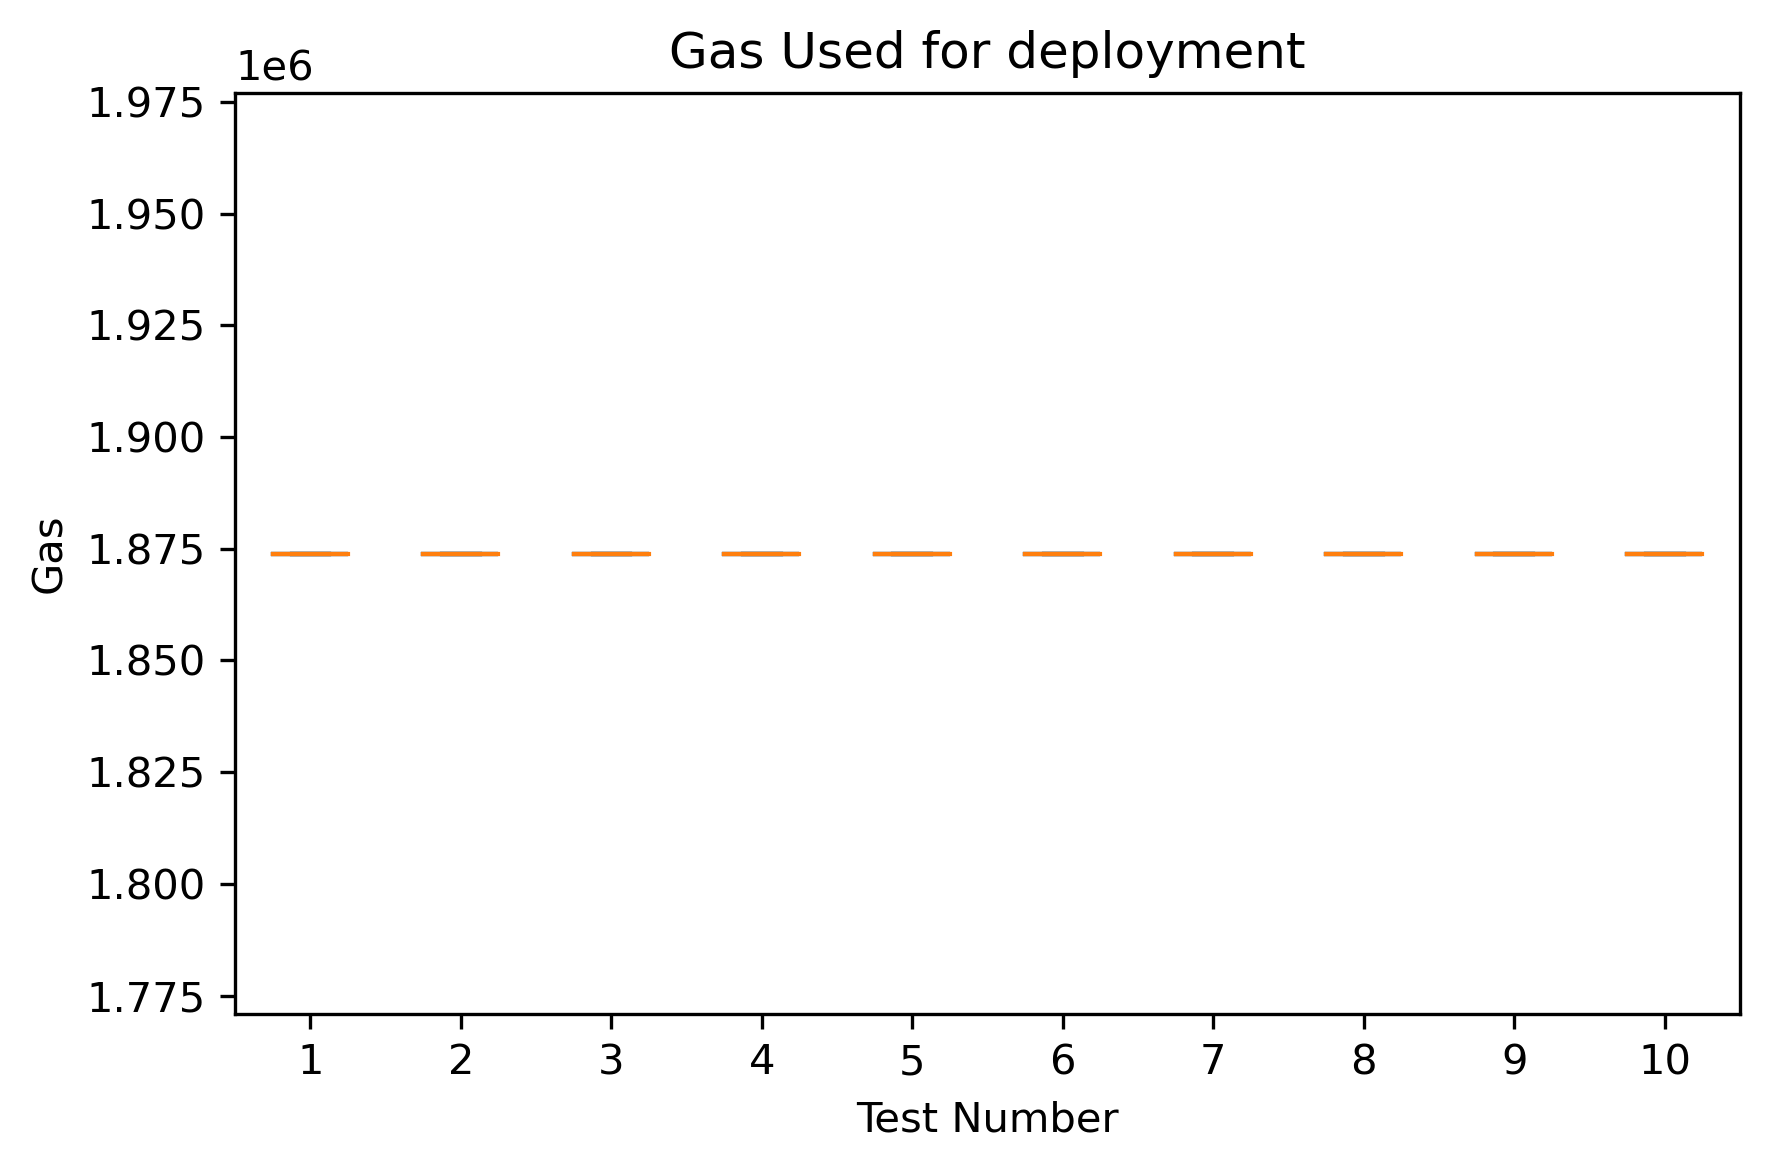

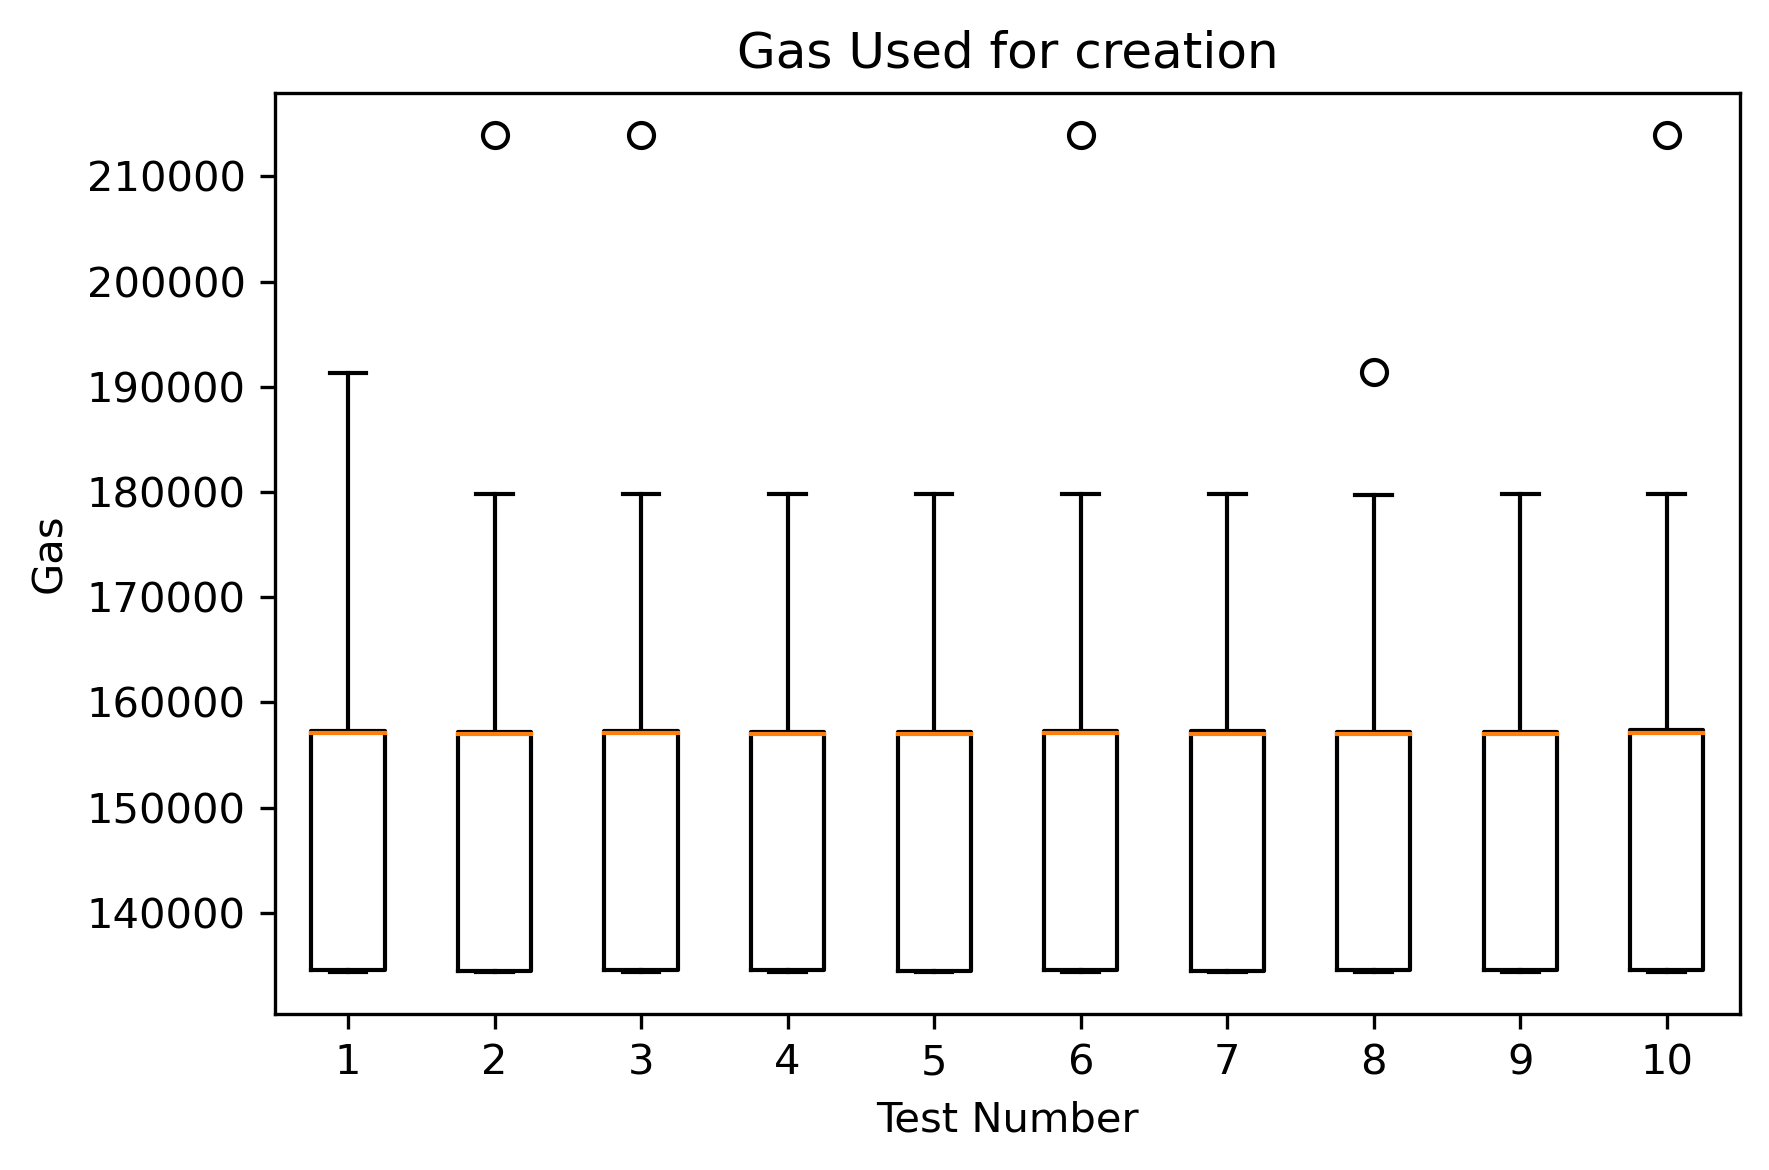

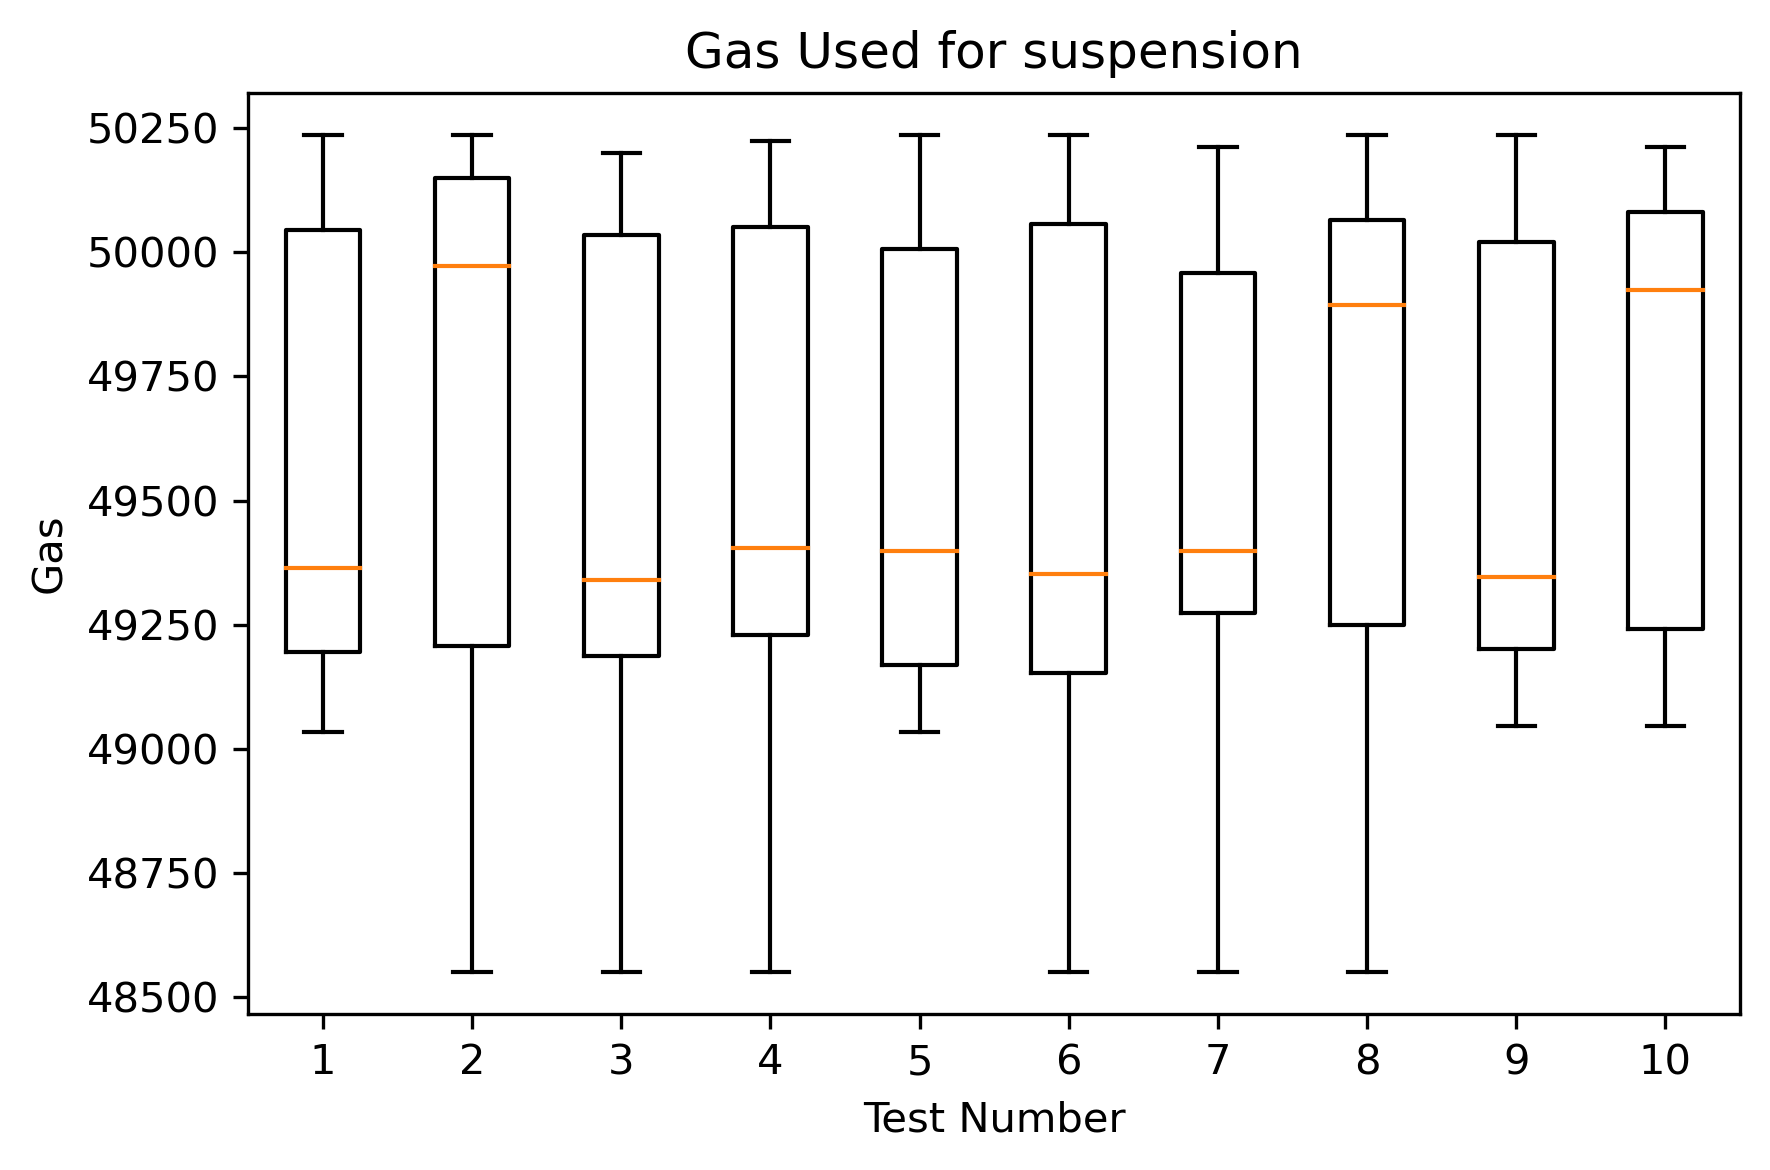

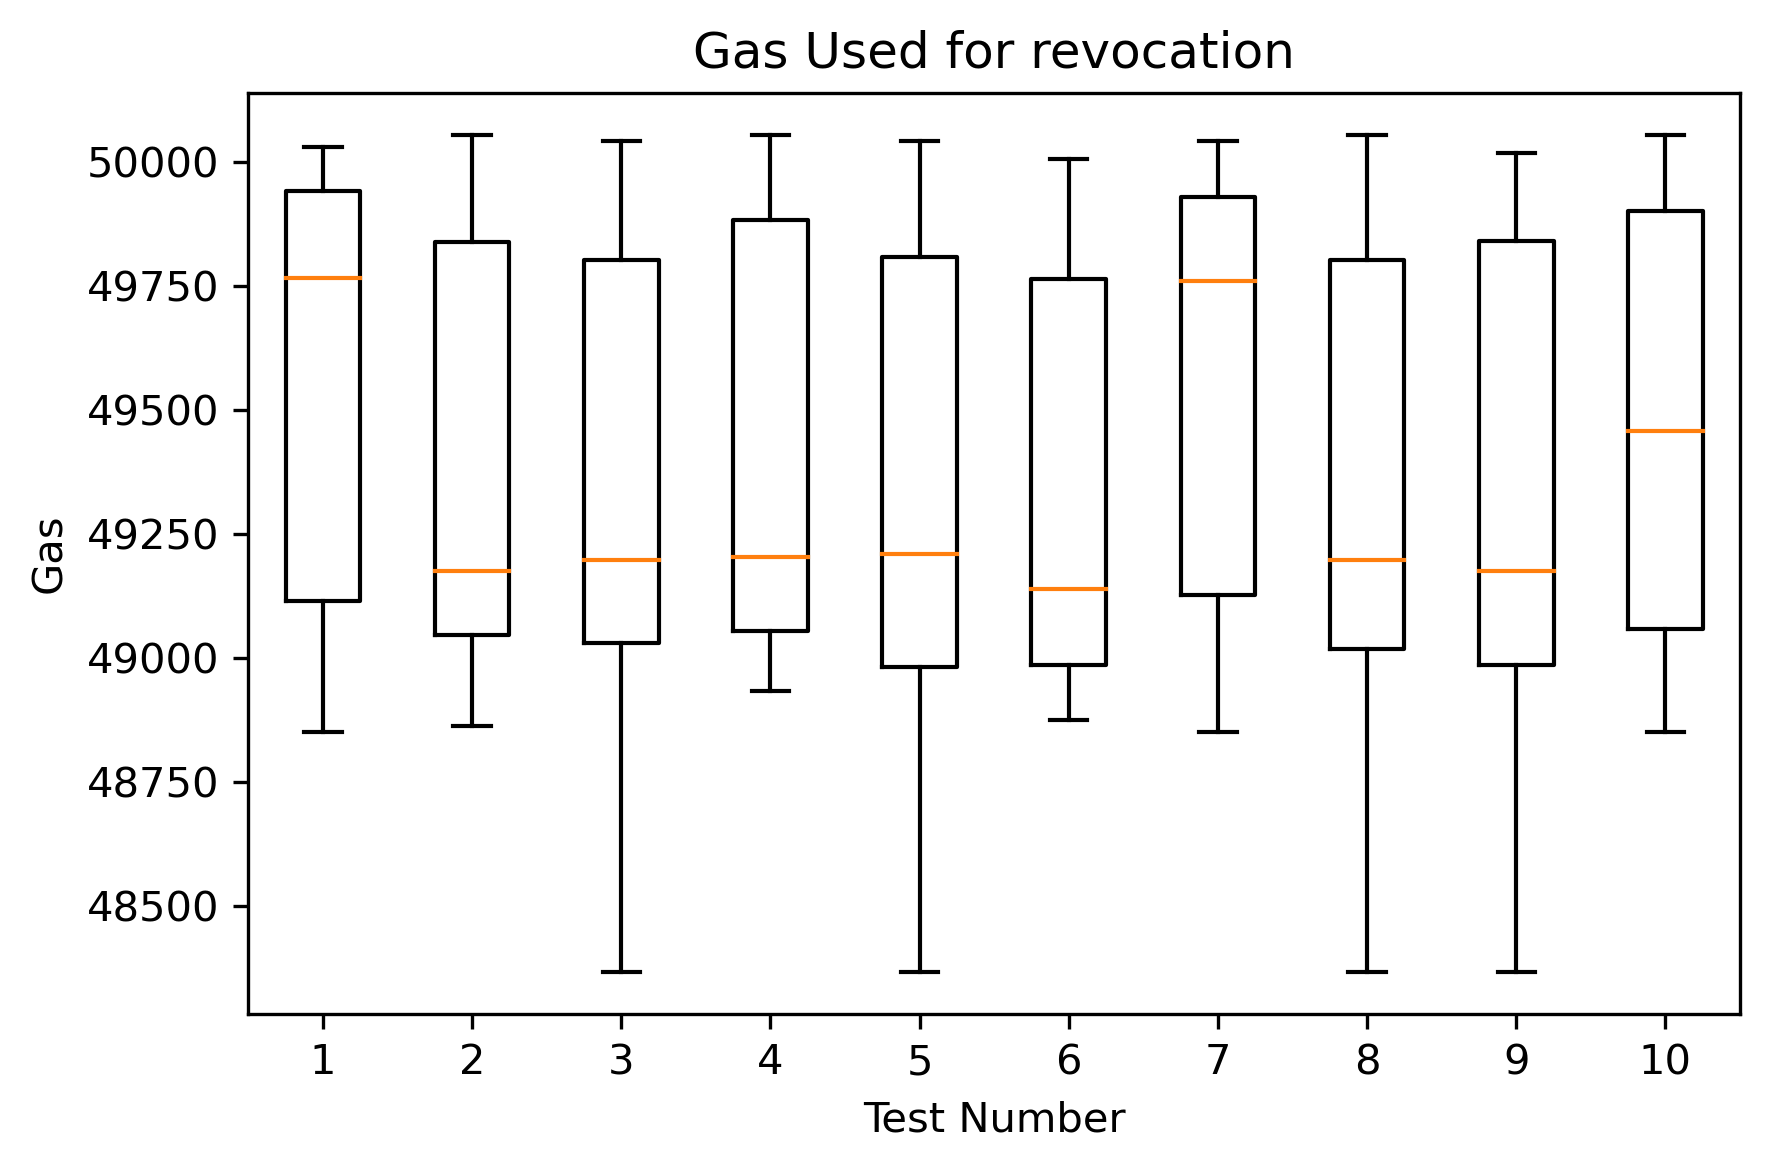

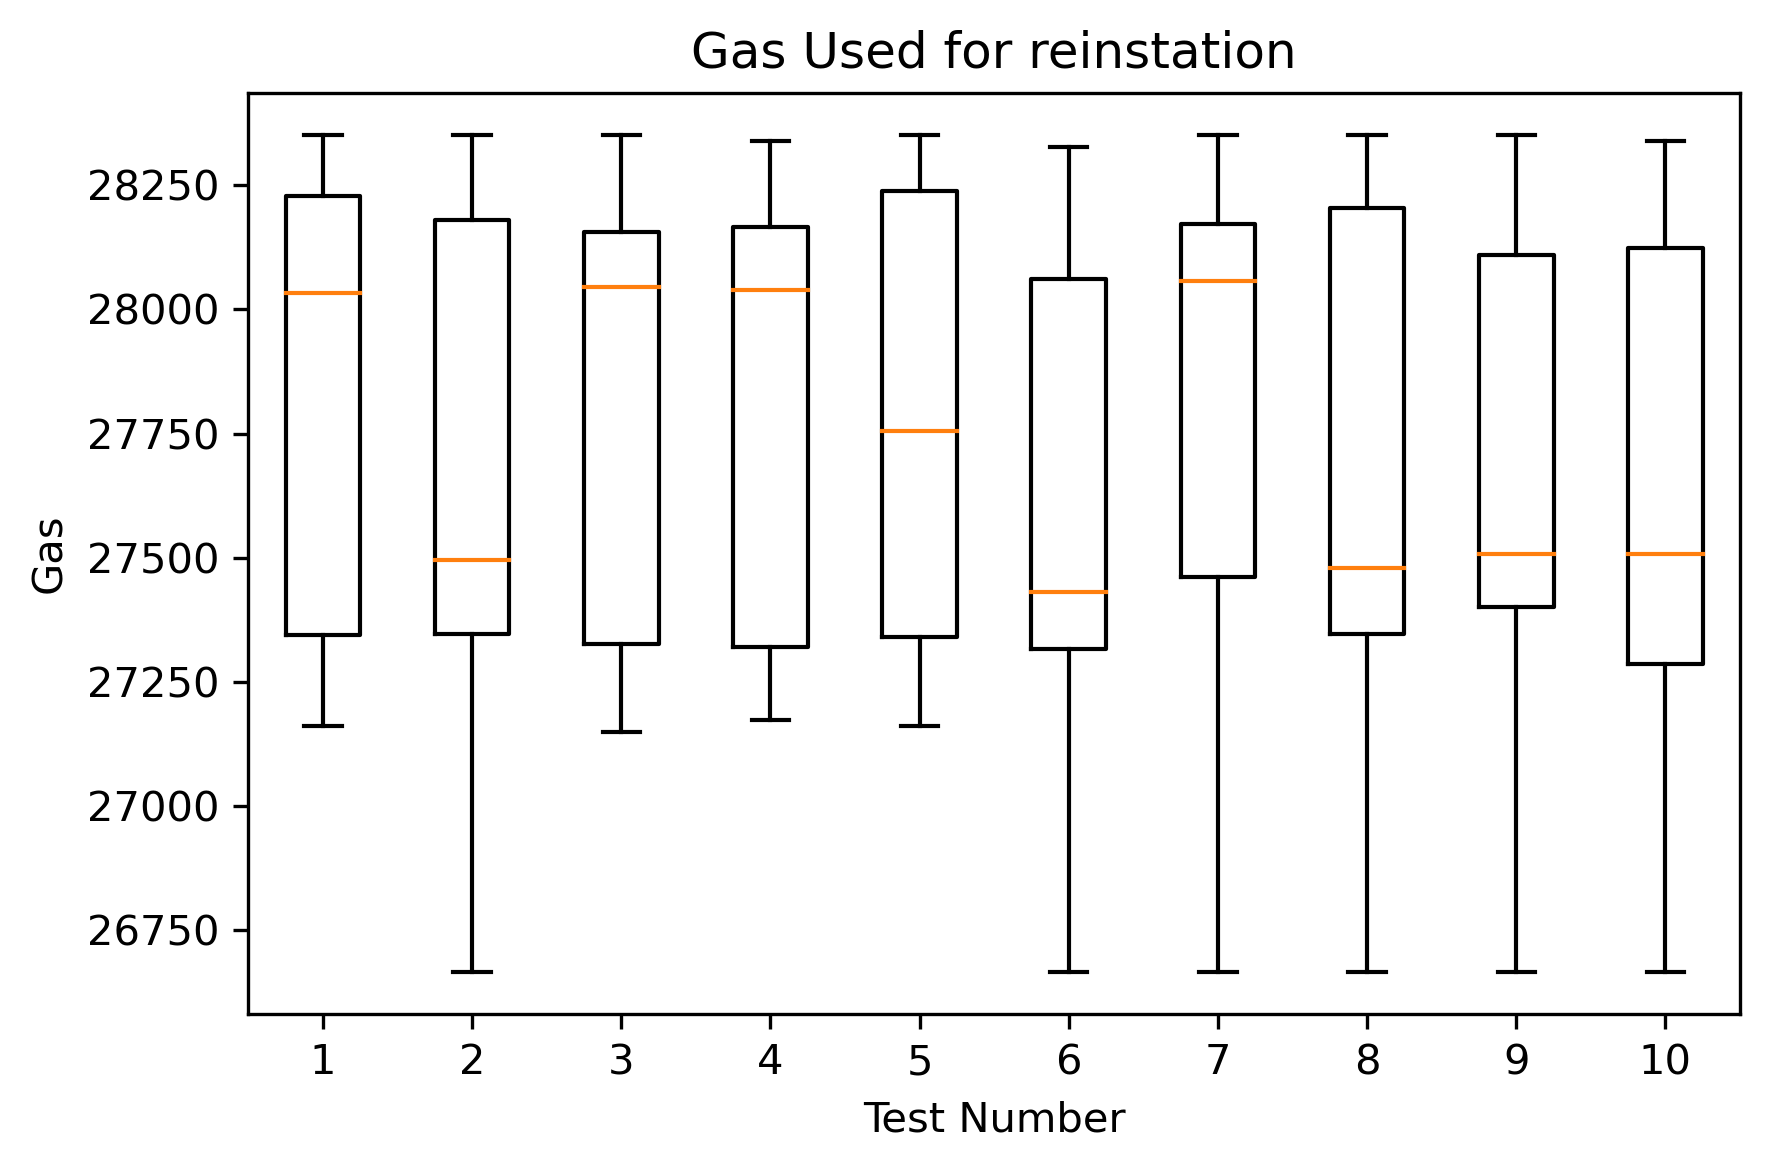

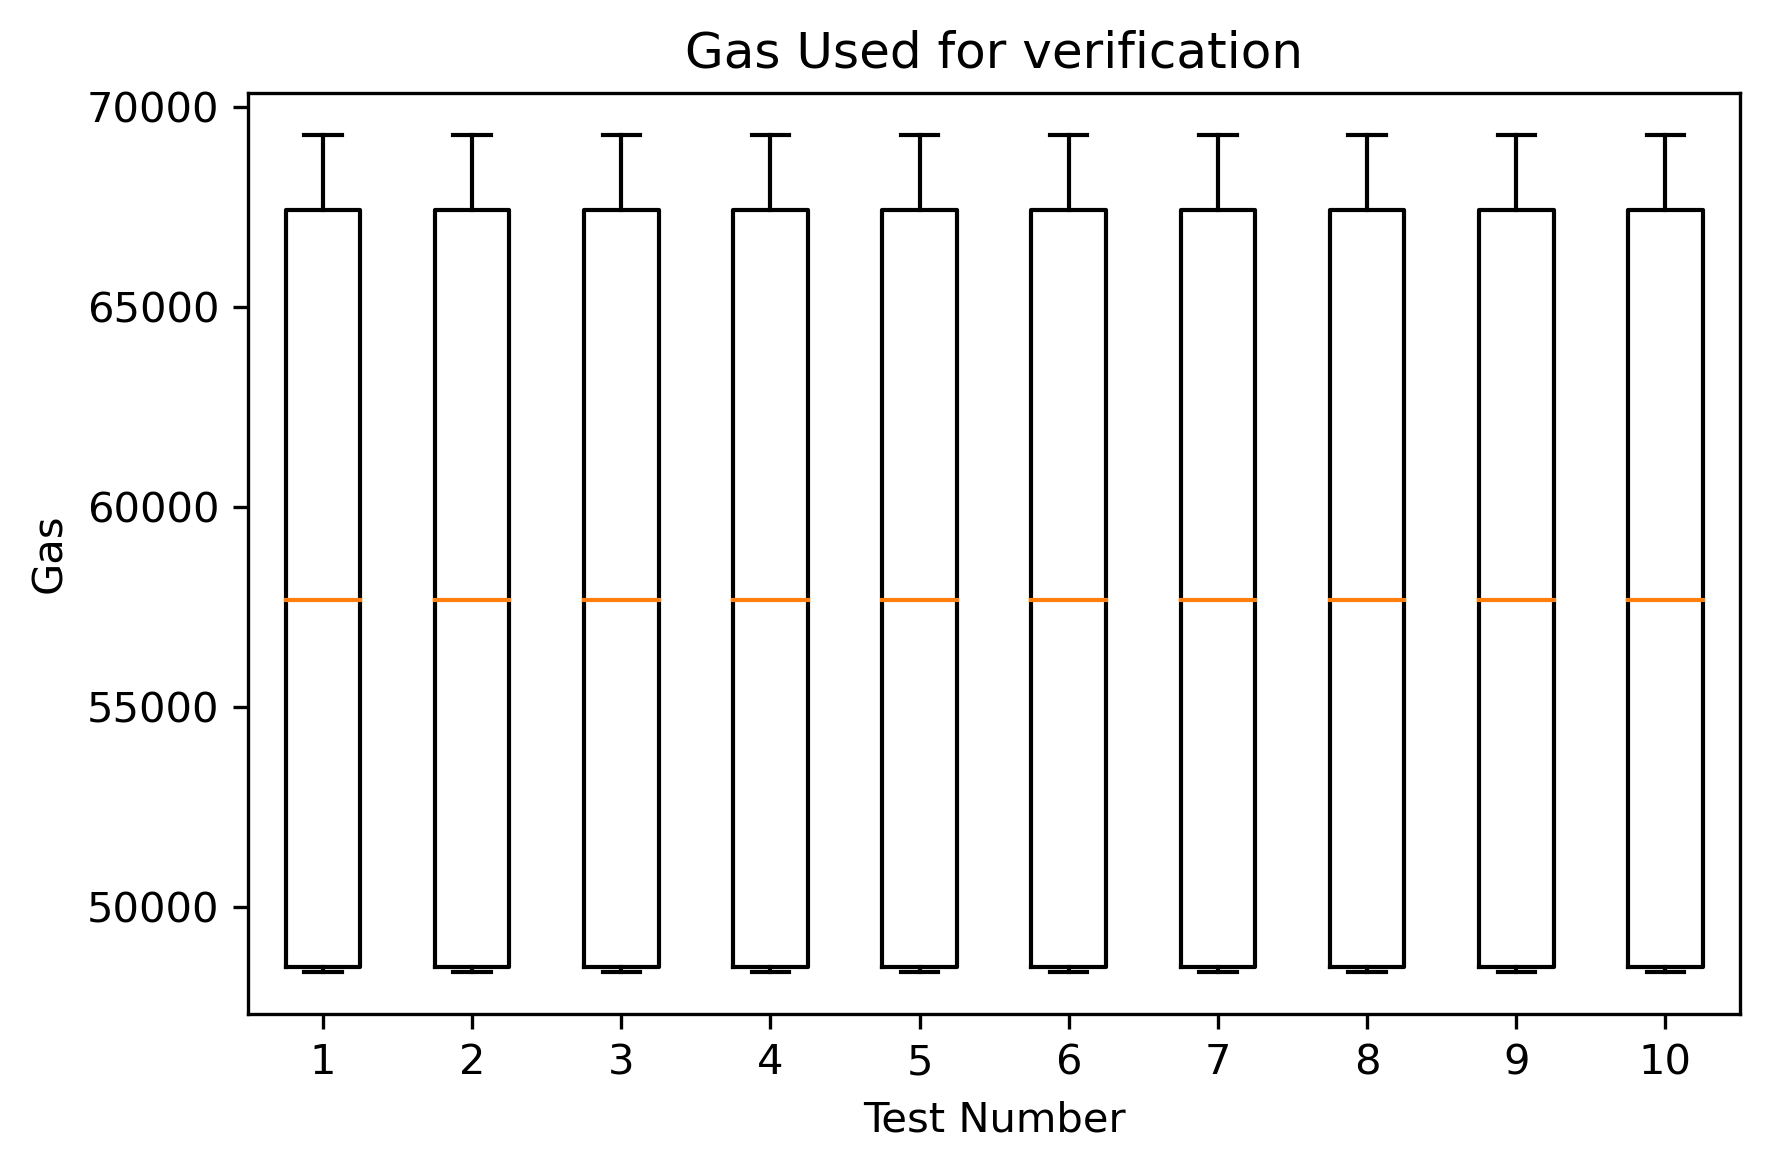

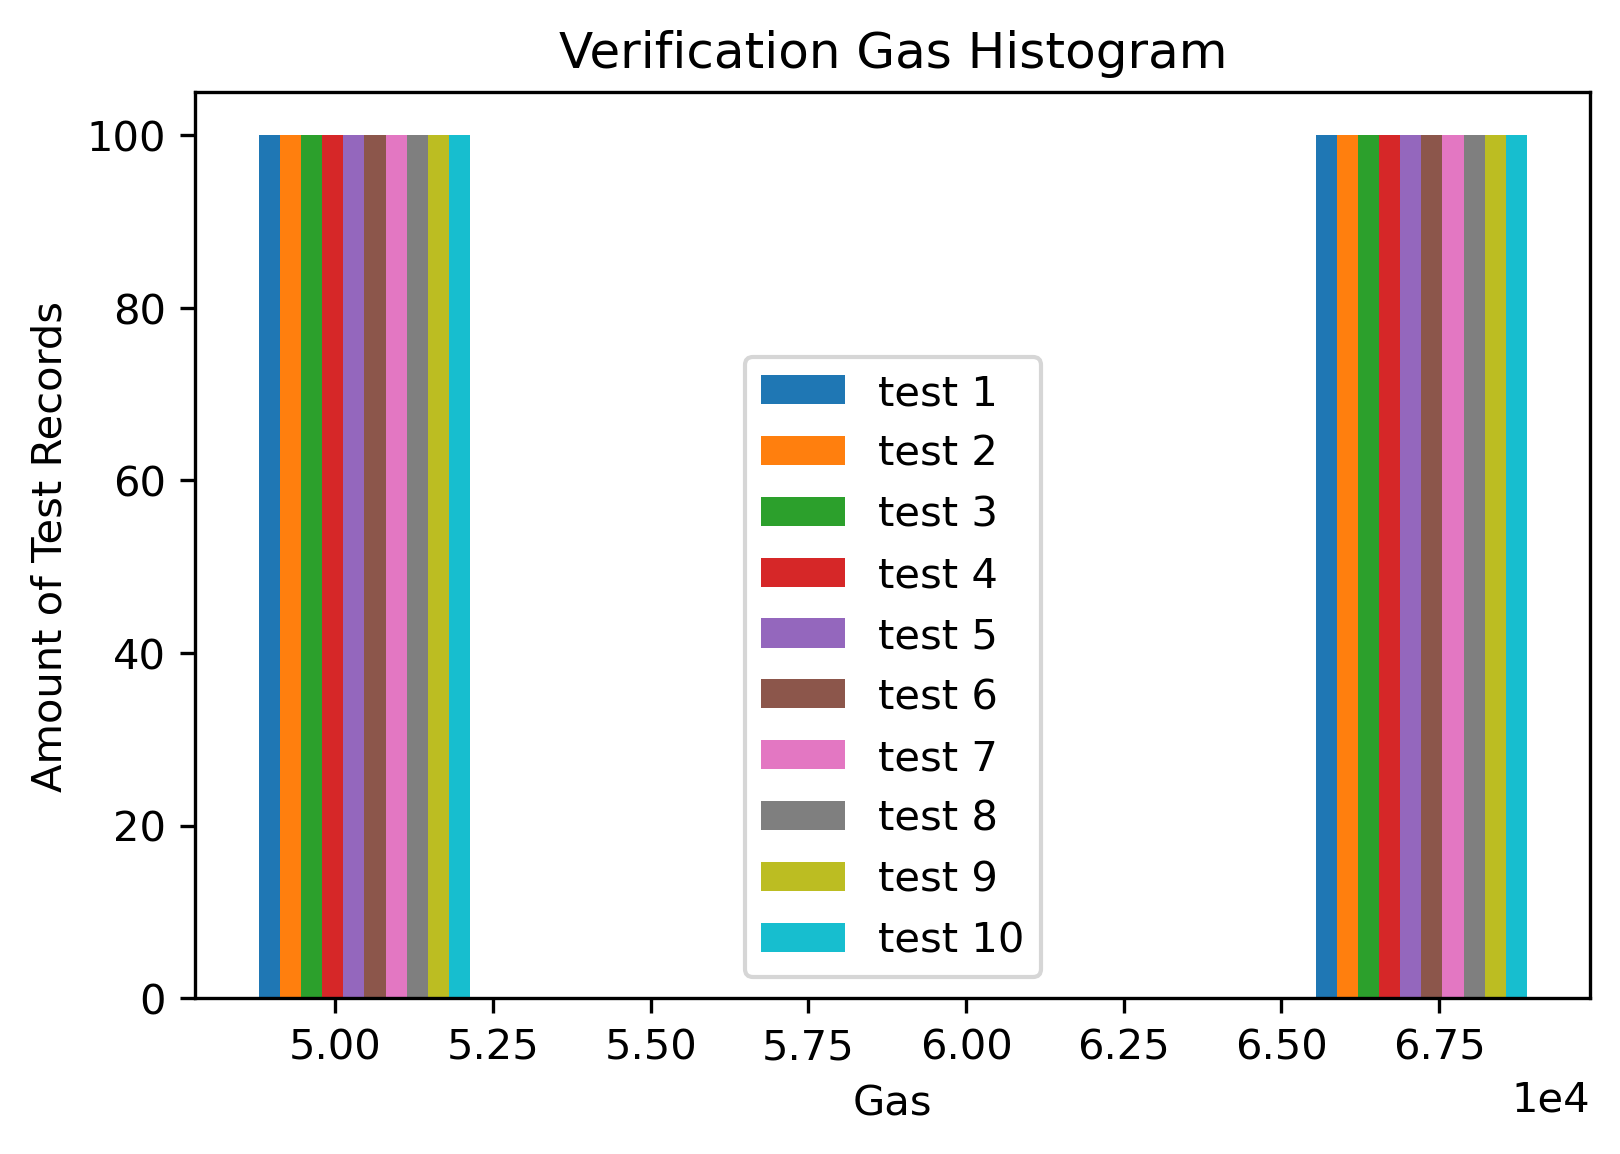

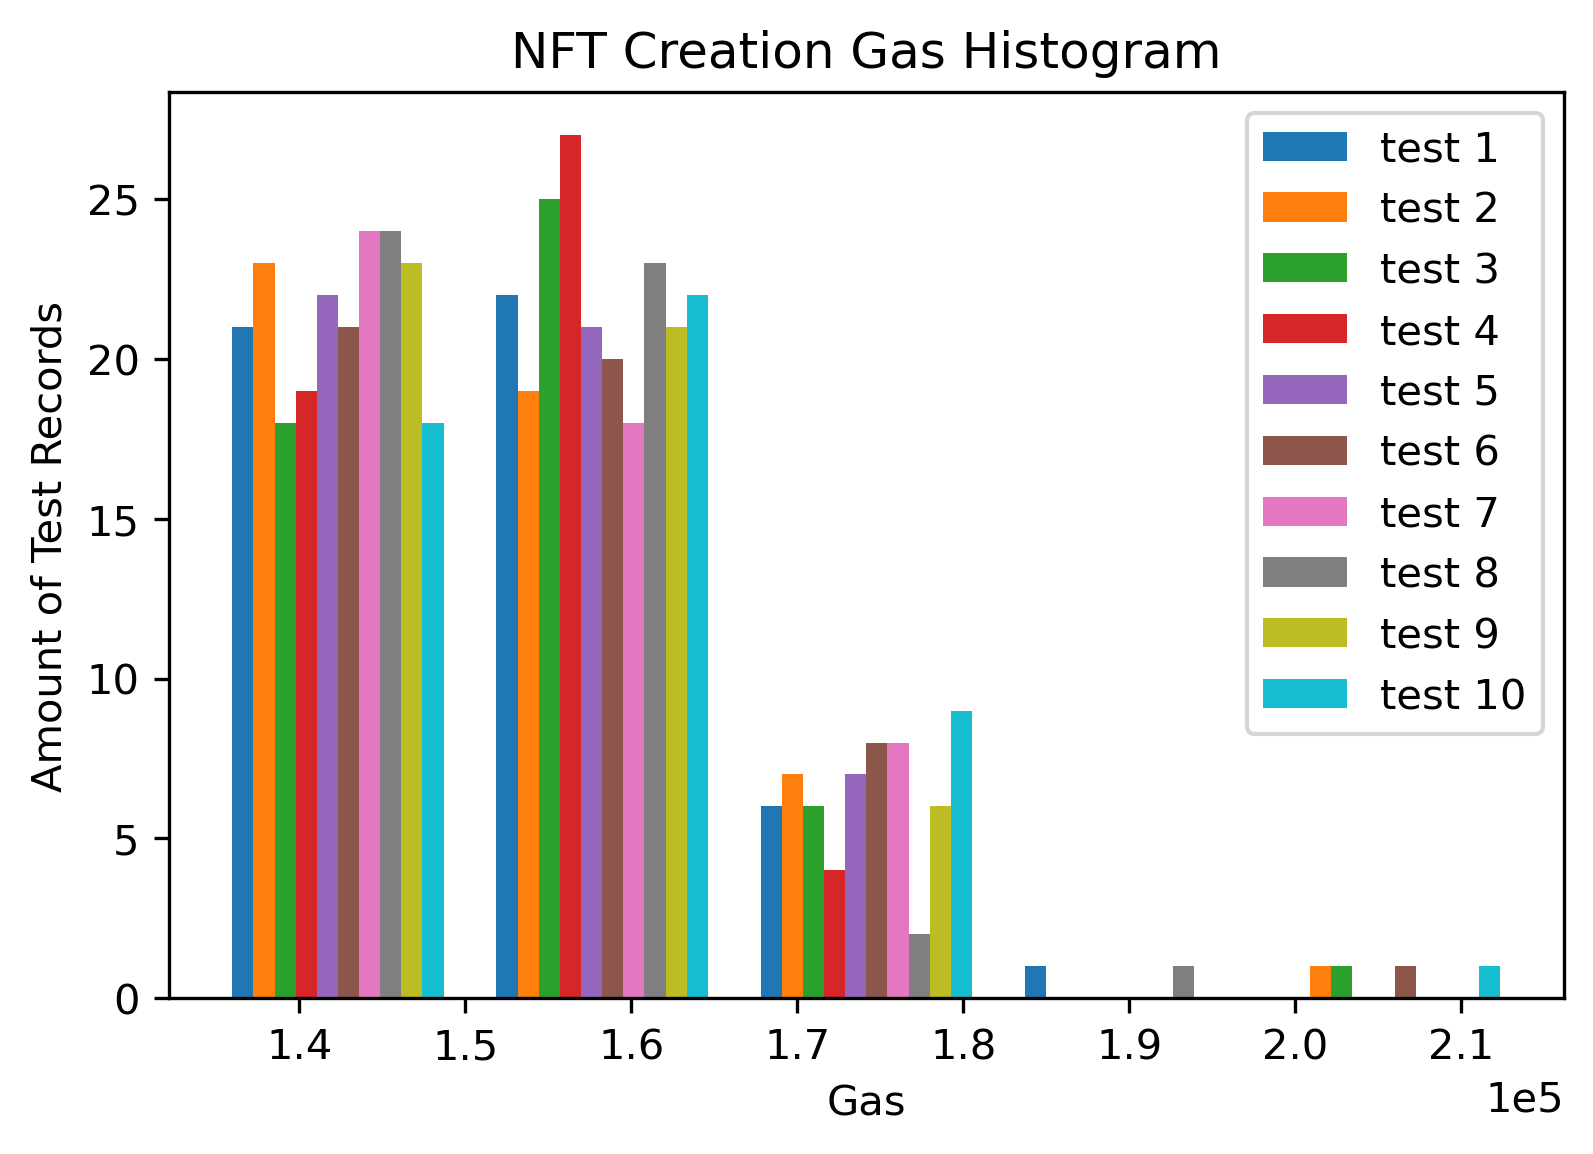

In [18]:
# Now the python code which generates graphs
metrics_path = path+"/metrics/"
graph_path = path+"/graphs/"

deployment = []
creation = []
suspension = []
revocation = []
reinstation = []
verification = []
now = datetime.now().isoformat()
test_path = os.path.join(graph_path, now)+"/"
try:
    os.mkdir(test_path)
except:
    pass
for filename in os.listdir(metrics_path):
    df = pd.read_csv(metrics_path+filename)
    df_method = df.groupby('method')
    # changing dytypes did not work, so doing this work around
    deployment.append([int(x) for x in df_method.get_group("deployment")["gas"].values])
    creation.append([int(x) for x in df_method.get_group("creation")["gas"].values])
    suspension.append([int(x) for x in df_method.get_group("suspension")["gas"].values])
    revocation.append([int(x) for x in df_method.get_group("revocation")["gas"].values])
    reinstation.append([int(x) for x in df_method.get_group("reinstation")["gas"].values])
    verification.append([int(x) for x in df_method.get_group("verification")["gas"].values])
    
box_plot(["deployment"], deployment, test_path)
box_plot(["creation"], creation, test_path)
box_plot(["suspension"],suspension, test_path)
box_plot(["revocation"],revocation, test_path)
box_plot(["reinstation"],reinstation, test_path)
box_plot(["verification"], verification, test_path)

# we get an intersting result for verification so create a histogram
plt.figure("verification_hist", dpi=300)
res = plt.hist(verification,5, label = ["test {}".format(x) for x in range(1,11)])
plt.title("Verification Gas Histogram")
plt.xlabel("Gas")
plt.ylabel("Amount of Test Records")
plt.legend() 
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='x')
plt.savefig(test_path+"verification_hist.jpg")


plt.figure("creation_hist", dpi=300)
res = plt.hist(creation,5,label = ["test {}".format(x) for x in range(1,11)])
plt.title("NFT Creation Gas Histogram")
plt.xlabel("Gas")
plt.ylabel("Amount of Test Records")
plt.legend() 
plt.ticklabel_format(style='sci',scilimits=(0,0),axis='x')
plt.savefig(test_path+"creation_hist.jpg")
